# PID

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import PIDGym

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmphhs1udlj
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmphhs1udlj/_remote_module_non_scriptable.py


## System

describe here

## Hyperparameters

In [4]:
name = 'pid'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 12000  # total timesteps
    T0 = 5000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # when to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    env_name = 'CartPoleContinuous-v1'  
    # env_name = 'MountainCarContinuous-v0'
    initial_Kp = 0.1  # initial values for K
    initial_Ki = 0.05
    initial_Kd = 0.05
    initial_control = jnp.array([initial_Kp, initial_Ki, initial_Kd])
    du = initial_control.shape[0]
    
    bounds = [(0, 1), (0, 1), (0, 1)]

    def apply_control(control, system): 
        system.pid.Kp = system.pid.Kp.at[0].set(control[0].item())     
        system.pid.Ki = system.pid.Ki.at[0].set(control[1].item())     
        system.pid.Kd = system.pid.Kd.at[0].set(control[2].item())        
        
    env_name = 'CartPole-v1'  
    # env_name = 'MountainCarContinuous-v0'

    system_args = {
        'env_name': env_name,
        'apply_control': apply_control,
        'control_dim': du,  # because CartPole
        'repeat': 10,
        'gym_repeat': 1,
        'max_episode_len': 300,
        'seed': SYSTEM_SEED,
        'Kp': initial_Kp,
        'Ki': initial_Ki,
        'Kd': initial_Kd
    }
    make_system = lambda : PIDGym(**system_args)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------
    
    dl = 4
    hh = 3
    
    observable = TimeDelayedObservation(hh = hh, control_dim=du, 
                                        use_states=False, use_controls=True, 
                                        use_costs=True, use_cost_diffs=False,
                                        use_time=False)
    do = observable.obs_dim    
    
    exploration_args = {'scales': 0.1, 'bounds': bounds, 'avg_len': 3,}
    sysid_args = {
        'obs_dim': do,
        'control_dim': du,

        'exploration_args': {'random 1.0': exploration_args,
    #                          'impulse 0.25': exploration_args,
                            },

        'method': 'nn',
        'AB_method': 'regression',
        'deterministic': False,
        'isometric': True,
        
        'sigma': 0,
        'depth': 8,
        'num_iters': 16000,
        'batch_size': 256,
        'lifter_lr': 0.001,
        'hh': hh,
        'initial_control': initial_control,

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 4  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
#     m0_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.1, beta=0.999)
    k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.4, beta=0.6)

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0, 0.01, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
#         'bounds': bounds,
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'use_stabilizing_K': True,
        'seed': CONTROLLER_SEED
    }
    
    make_controllers = {
#         'Lifted LQR': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=LQR(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted HINF': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=HINF(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted GPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=GPC(sysid.A, sysid.B, decay=False, lr_scale=0.01, H=10), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
        'Lifted EvanBPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=EvanBPC(sysid.A, sysid.B, **nonlinear_bpc_args), lifter=sysid),
                                          sysid=Lifter(state_dim=dl, **sysid_args), T0=T0)
    }

    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [5]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Lifted EvanBPC
INFO: (EXPLORER) generating exploration control sequences using ['random'] w.p. [1.]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 341.69it/s]
INFO: (LIFTER): we will be linearizing in latent dimension 9 and linearly project down to embedding dimension 4
INFO: (LIFTER): we are imposing simplification as a hard constraint on the latent space via isometric NN
INFO: (LIFTER): using "regression" method to get the AB matrices during each training step
 42%|████████████████████▍                            | 4990/12000 [00:28<00:43, 162.39it/s, control=[0.15414484 0.1442827  0.10045987], cost=0.0189]INFO: (SYSID WRAPPER) ending exploration at timestep 50

regression (ret) :
||A||_op = 17.670480728149414
||B||_F = 0.061321962624788284
||A-BK||_op = 17.500003814697266
eig(A) = [0.93144006 0.39310753 0.39310753 0.02943169]
svd(B) = [0.06122435 0.00294745 0.00180988]

moments :
||A||_op = 1.001153826713562
||B||_F = 0.012900344096124172
||A-BK||_op = 0.9886873364448547
eig(A) = [9.9962246e-01 1.0760673e-03 1.0760673e-03 2.0864265e-05]
svd(B) = [1.2900318e-02 2.3118668e-05 1.0698697e-05]



100%|█████████████████████████████████████████████████| 12000/12000 [03:15<00:00, 61.52it/s, control=[0.05712698 0.0025811  0.16404742], cost=0.0163]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 210.0229837918887 seconds


{'states'}


In [ ]:
# # save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
# #                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [6]:
def plot_pid(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot system stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'P', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
        stats.plot(ax[1, 1], 'Kp', label=method + ' Kp')
        stats.plot(ax[1, 1], 'Kd', label=method + ' Kd')

        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'costs', label=method)

        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('error'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('state'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('instantaneous costs'); _ax.legend()
    pass

### Plot

<Figure size 640x480 with 0 Axes>

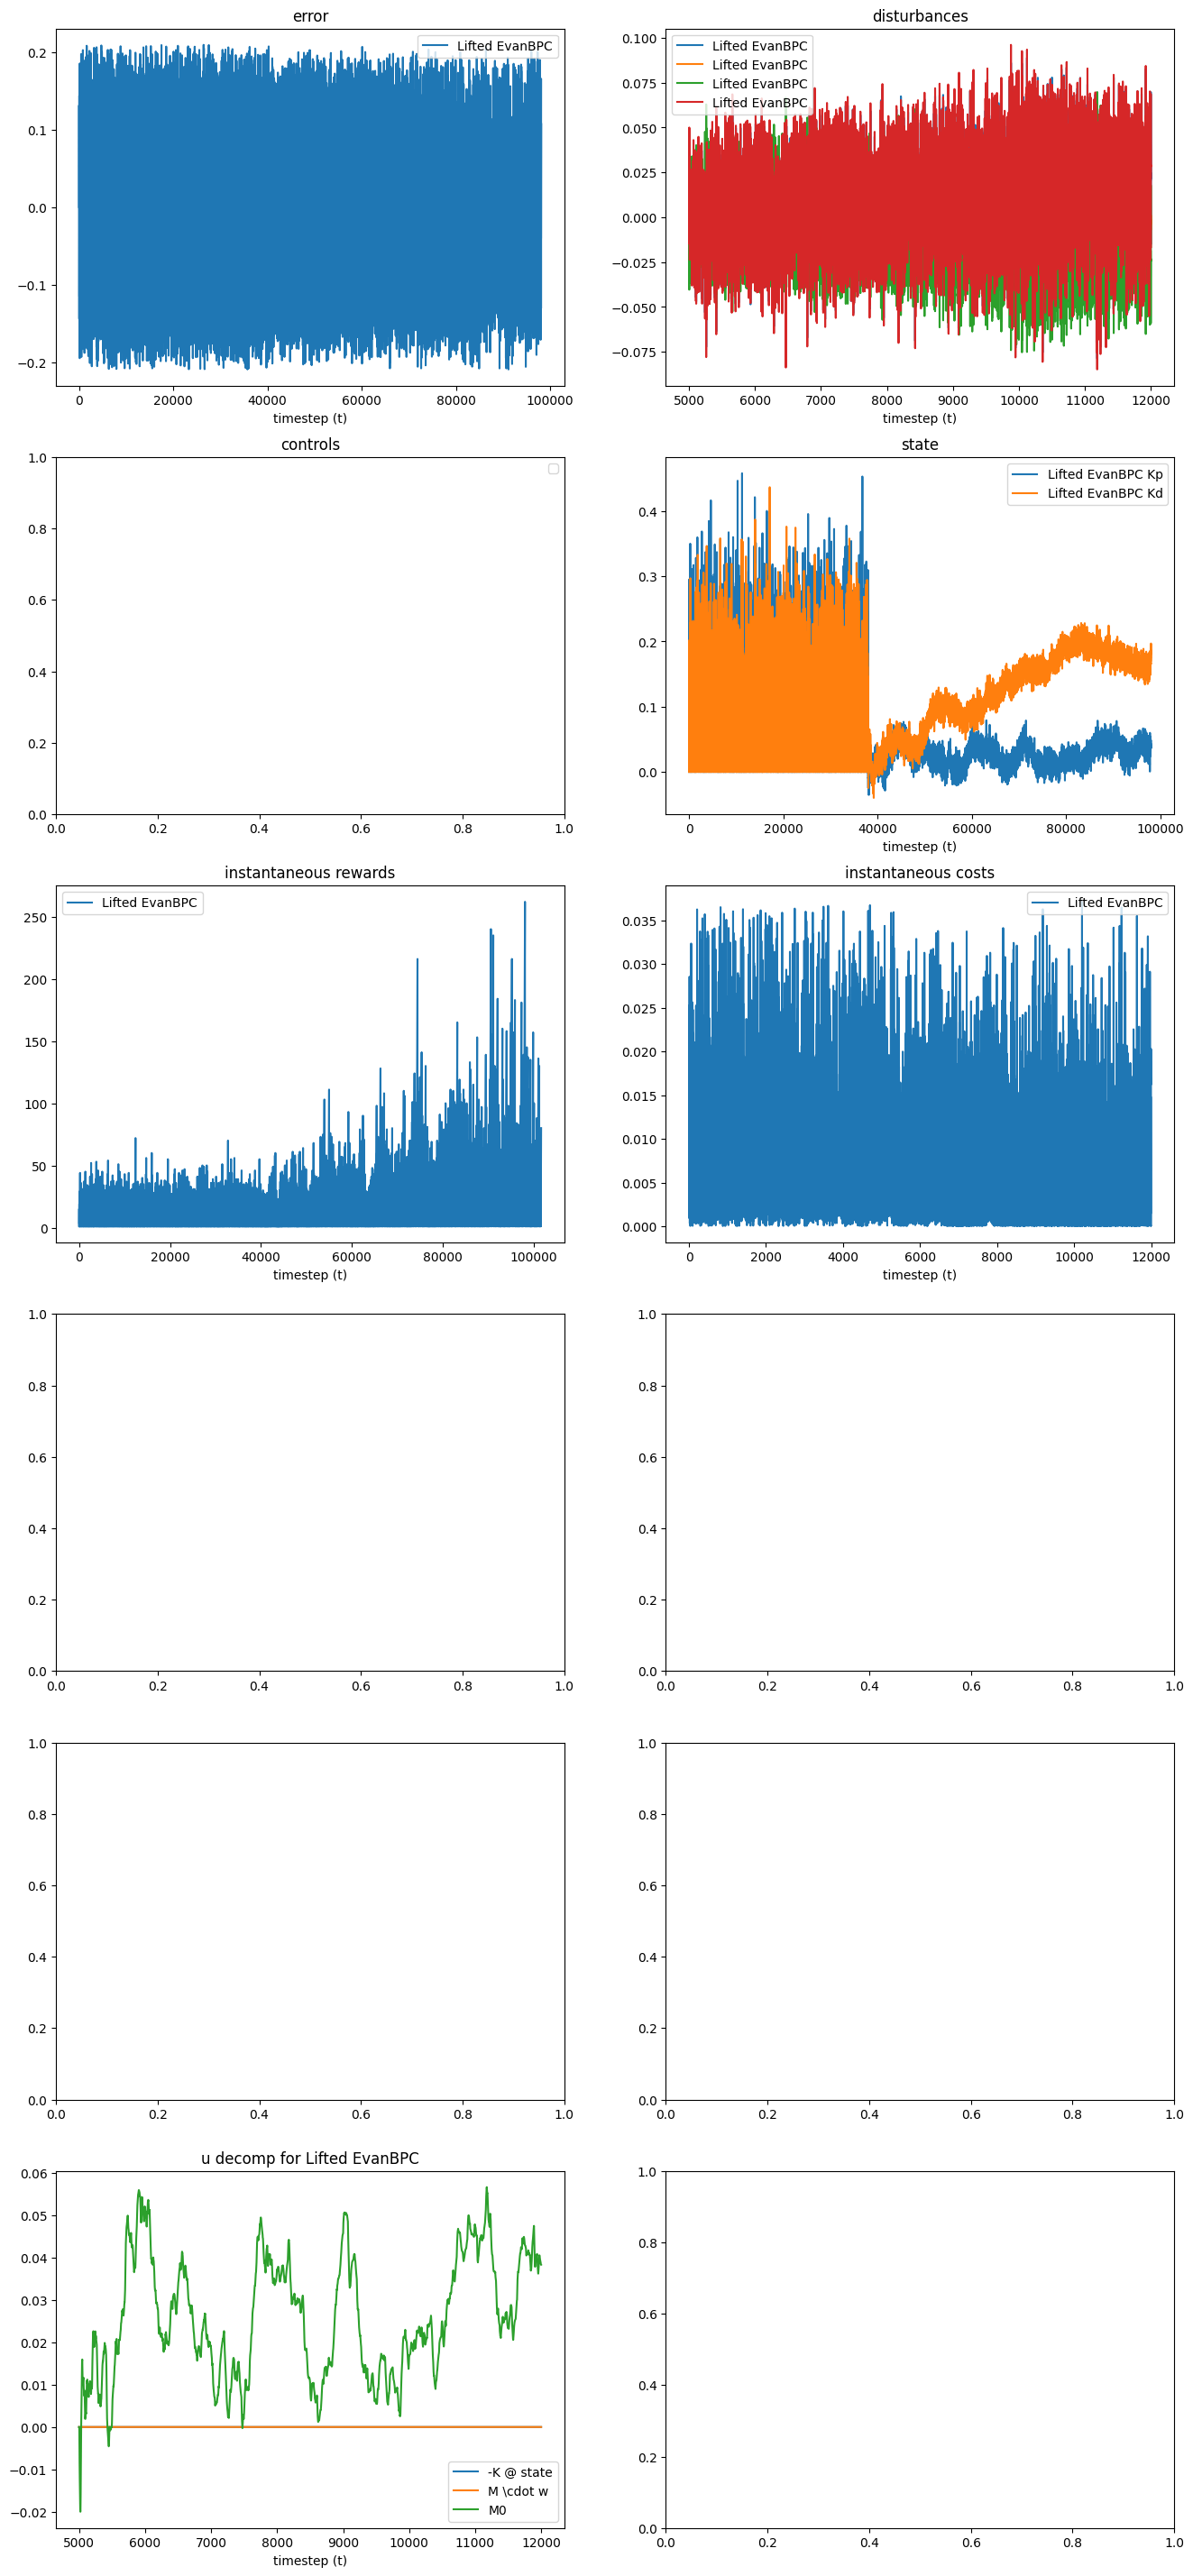

In [7]:
plot_pid(experiment)
# # plot
# from copy import deepcopy
# e = deepcopy(experiment)
# e.stats = {k: s[4100:] for k, s in e.stats.items() if k not in ['No Lift', 'RBPC']}
# plot_pid(e)

### Dynamic Plot

In [ ]:
# dynamic plot
anim = render(experiment, 'Kp', 'rewards', sliderkey='us', save_path=None, duration=5)
vid = anim.to_html5_video()
HTML(vid)